In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torchvision.transforms import functional as FT

import torch.nn.functional as F
from torch import Tensor

import os
import numpy as np

from torch import optim
from tqdm import tqdm

import datetime
import matplotlib.pyplot as plt

# Load the Data

In [3]:
train_images = np.load("/content/drive/MyDrive/VCS Project/dataset/train/images/images.npy", allow_pickle=True)
train_masks = np.load("/content/drive/MyDrive/VCS Project/dataset/train/masks/masks.npy", allow_pickle=True)

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# from torchvision.transforms import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class ProstateMRIDataset(Dataset):
    def __init__(self, images, masks, transform=None, device=device):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.target_size = masks[0].shape
        self.device = device

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        image = torch.from_numpy(image).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)

        image = FT.resize(image, self.target_size, antialias=True)
        mask = FT.resize(mask, self.target_size, interpolation=FT.InterpolationMode.NEAREST, antialias=True)

        # Ensure the number of channels is consistent
        # print(image.shape)
        assert image.shape[0] == 1, "Input image must have a single channel"
        assert mask.shape[0] == 1, "Target mask must have a single channel"


        combined_mask = torch.stack([(mask == 0).float(), (mask == 1).float(), (mask == 2).float()], dim=0)
        # combined_mask = combined_mask.permute(1, 2, 3, 0)

        return image.to(self.device), combined_mask.to(self.device)

In [6]:
from sklearn.model_selection import train_test_split

test_size_initial = 0.2

train_images_filtered, test_images_filtered, train_masks_filtered, test_masks_filtered = train_test_split(
    train_images, train_masks, test_size=test_size_initial, random_state=42)

validation_size = 0.1

train_images_filtered, validation_images_filtered, train_masks_filtered, validation_masks_filtered = train_test_split(
    train_images_filtered, train_masks_filtered, test_size=validation_size, random_state=42)

In [7]:
def flatten_slices(images):
    return np.array([image[:, :, i] for image in images for i in range(image.shape[2])])

train_images_flatten = flatten_slices(train_images_filtered)
train_masks_flatten = flatten_slices(train_masks_filtered)

validation_images_flatten = flatten_slices(validation_images_filtered)
validation_masks_flatten = flatten_slices(validation_masks_filtered)

test_images_flatten = flatten_slices(test_images_filtered)
test_masks_flatten = flatten_slices(test_masks_filtered)

<ipython-input-7-b13430ce0285>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image[:, :, i] for image in images for i in range(image.shape[2])])


In [8]:
print(len(train_images_flatten))

1067


# Histogram Equalisation

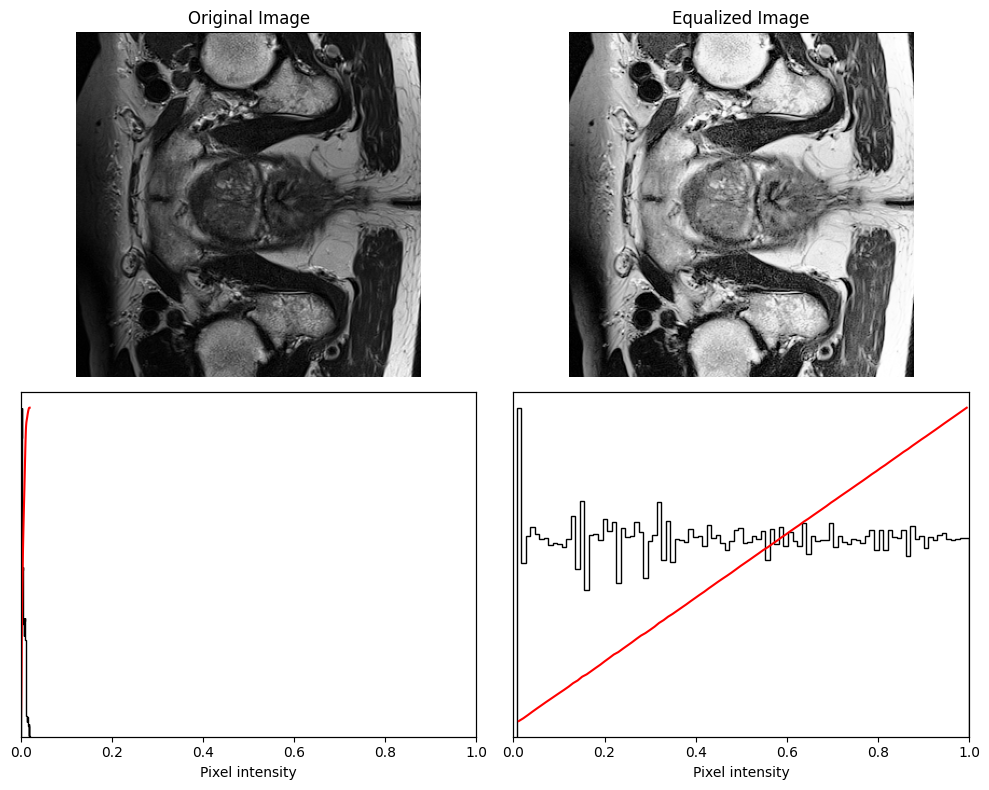

In [9]:
from skimage import exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np

def hist_equalise(dataset):
    # Perform histogram equalization on each scan slice
    for i in range(len(dataset)): # Over subjects
          dataset[i] = exposure.equalize_hist(dataset[i])

def plot_img_and_hist(image, axes, bins=100):
    # Plot an image along with its histogram and cumulative histogram.
    # Code adapted from: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

def plot_histogram_equalisation(img_org, img_heq):
    # Plot original low contrast image and histogram eualised image, with their histograms and cumulative histograms.
    # Code adapted from: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

    fig = plt.figure(figsize=(7, 7))
    axes = np.zeros((2, 2), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 2, 1)
    for i in range(1, 2):
        axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 2):
        axes[1, i] = fig.add_subplot(2, 2, 3+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_org, axes[:, 0])
    ax_img.set_title('Original low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_heq, axes[:, 1])
    ax_img.set_title('Histogram equalised image')

    ax_cdf.set_ylabel('Fraction of total intensity', color='red')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    fig.tight_layout(h_pad=-1.5)
    plt.show()

def visualize_histogram_equalization(original, equalized):
    # Visualize original and equalized images with their histograms
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    plot_img_and_hist(original, axes[:, 0])
    axes[0, 0].set_title('Original Image')

    plot_img_and_hist(equalized, axes[:, 1])
    axes[0, 1].set_title('Equalized Image')

    plt.tight_layout()
    plt.show()


# Visualize the results for a single subject and slice (modify indices as needed)
subject_index = 8
original_image = train_images_flatten[subject_index]
equalized_image = exposure.equalize_hist(original_image)

# Visualize the results
visualize_histogram_equalization(original_image, equalized_image)

# Apply histogram equalization to the datasets
hist_equalise(train_images_flatten)
hist_equalise(validation_images_flatten)
hist_equalise(test_images_flatten)

# Data Augmentation

In [10]:
from scipy.ndimage import map_coordinates, gaussian_filter
import scipy
import time
import numpy as np
import random

def rotate(voxels, lbls, theta=None):
    # Rotate volume by a minor angle (+/- 10 degrees: determined by investigation of dataset variability)
    if theta is None:
        theta = random.randint(-10, 10)
    vox_new = scipy.ndimage.rotate(voxels, theta, reshape=False)
    lbl_new = scipy.ndimage.rotate(lbls, theta, reshape=False)
    return vox_new, lbl_new


def scale_and_crop(voxels, lbls):
    # Scale the volume by a minor size and crop around centre (can also modify for random crop)
    o_s = voxels.shape
    r_s = [0] * len(o_s)
    scale_factor = random.uniform(1, 1.2)
    vox_zoom = scipy.ndimage.zoom(voxels, scale_factor, order=1)
    lbl_zoom = scipy.ndimage.zoom(lbls, scale_factor, order=0)
    new_shape = vox_zoom.shape
    # Start with offset
    for i in range(len(o_s)):
        if new_shape[i] == 1:
            r_s[i] = 0
            continue
        r_c = int(((new_shape[i] - o_s[i]) - 1) / 2)
        r_s[i] = r_c
    r_e = [r_s[i] + o_s[i] for i in range(len(o_s))]

    # Adjust indexing for 2D arrays
    vox_zoom = vox_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1]]
    lbl_zoom = lbl_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1]]


    return vox_zoom, lbl_zoom

def grayscale_variation(voxels, lbls):
    # Introduce a random global increment in gray-level value of volume.
    im_min = np.min(voxels)
    im_max = np.max(voxels)
    mean = np.random.normal(0, 0.1)
    smp = np.random.normal(mean, 0.01, size=np.shape(voxels))
    voxels = voxels + im_max * smp
    voxels[voxels <= im_min] = im_min  # Clamp to min value
    voxels[voxels > im_max] = im_max  # Clamp to max value
    return voxels, lbls


def elastic_deformation(voxels, lbls, alpha=None, sigma=None, mode="constant", cval=0, is_random=False):
    # Apply elastic deformation/distortion to the volume
    # Adapted from: https://tensorlayer.readthedocs.io/en/stable/_modules/tensorlayer/prepro.html#elastic_transform
    if alpha is None:
        alpha = voxels.shape[0] * 3.0
    if sigma is None:
        sigma = voxels.shape[0] * 0.07
    if is_random is False:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(int(time.time()))

    shape = voxels.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    x_, y_ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x_ + dx, (-1, 1)), np.reshape(y_ + dy, (-1, 1))

    new_voxels = np.zeros_like(voxels)
    new_lbls = np.zeros_like(lbls)
    new_voxels[:, :] = map_coordinates(voxels[:, :], indices, order=1).reshape(shape[:2])
    new_lbls[:, :] = map_coordinates(lbls[:, :], indices, order=1).reshape(shape[:2])

    return new_voxels, new_lbls

def get_random_perturbation(voxels, lbls):
    # Generate a random perturbation of the input feature + label
    new_voxels, new_lbls = voxels, lbls
    p = 0.6
    if random.random() < p:
        new_voxels, new_lbls = rotate(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = scale_and_crop(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = grayscale_variation(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = elastic_deformation(new_voxels, new_lbls)
    return new_voxels, new_lbls

In [11]:
import copy

# Assuming train_images_filtered and train_masks_filtered are your original datasets
# Create new lists to store augmented images and masks
augmented_train_images = []
augmented_train_masks = []

# Number of augmentations per original pair
num_augmentations = 2

# Apply perturbation and save augmented pairs
for i in range(len(train_images_flatten)):
    original_image = train_images_flatten[i]
    original_mask = train_masks_flatten[i]

    augmented_train_images.append(original_image)
    augmented_train_masks.append(original_mask)

    for _ in range(num_augmentations):
        augmented_image, augmented_mask = get_random_perturbation(copy.deepcopy(original_image),
                                                                  copy.deepcopy(original_mask))
        augmented_train_images.append(augmented_image)
        augmented_train_masks.append(augmented_mask)

In [12]:
train_dataset = ProstateMRIDataset(np.array(augmented_train_images), np.array(augmented_train_masks), device)
validation_dataset = ProstateMRIDataset(np.array(validation_images_flatten), np.array(validation_masks_flatten), device)
test_dataset = ProstateMRIDataset(np.array(test_images_flatten), np.array(test_masks_flatten), device)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-12-450b72260cd9>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_dataset = ProstateMRIDataset(np.array(augmented_train_images), np.array(augmented_train_masks), device)


https://arxiv.org/pdf/1511.00561.pdf

https://github.com/vinceecws/SegNet_PyTorch/tree/master

# Define Metrics

In [13]:
def compute_iou_and_dice(pred_mask, true_mask, eps: float = 1e-7):
    intersection = torch.logical_and(true_mask, pred_mask).sum().item()
    union = torch.logical_or(true_mask, pred_mask).sum().item()

    iou = intersection / (union + eps)
    dice = 2 * (intersection) / (true_mask.sum().item() + pred_mask.sum().item() + eps)

    return iou, dice

In [14]:
def compute_accuracy(pred_mask, true_mask):
    correct_pixels = torch.sum((pred_mask == 1) & (true_mask == 1)).item()
    total_pixels = torch.sum(true_mask == 1).item()
    accuracy = correct_pixels / total_pixels if total_pixels != 0 else 0.0
    return accuracy

## Test the metrics on the validation set

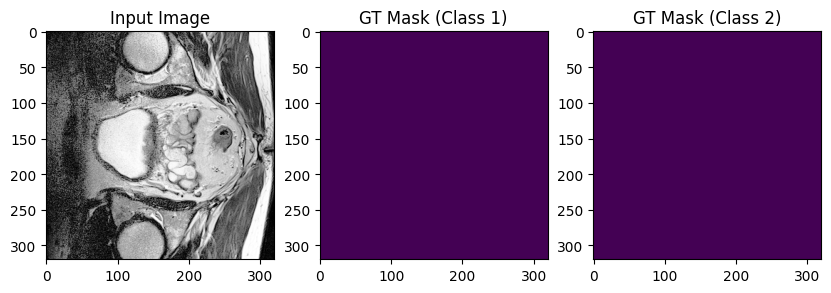

Val IoU (Class 1): 0.0000, 
Val Dice (Class 1): 0.0000, 
Val IoU (Class 2): 0.0000, 
Val Dice (Class 2): 0.0000


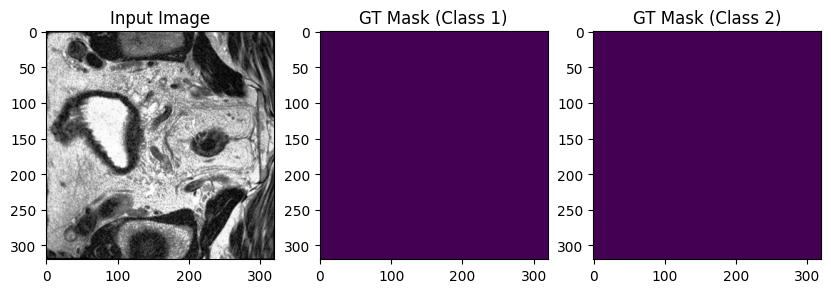

Val IoU (Class 1): 0.0000, 
Val Dice (Class 1): 0.0000, 
Val IoU (Class 2): 0.0000, 
Val Dice (Class 2): 0.0000


In [15]:
for idx, batch in enumerate(validation_loader):
  if idx >= 4:
    break
  elif idx == 1:
    images, combined_masks = batch[0].to(device), batch[1].to(device)
    true_mask1 = combined_masks.squeeze(2)
    iou_class1, dice_class1 = compute_iou_and_dice(true_mask1[0, 1, :, :] > 0.5, true_mask1[0, 1, :, :])
    iou_class2, dice_class2 = compute_iou_and_dice(true_mask1[0, 2, :, :] > 0.5, true_mask1[0, 2, :, :])

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask1[0][1].cpu().squeeze().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.title('GT Mask (Class 1)')

    plt.subplot(1, 3, 3)
    plt.imshow(true_mask1[0][2].cpu().squeeze().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.title('GT Mask (Class 2)')
    plt.show()

    print(f"Val IoU (Class 1): {iou_class1:.4f}, ")
    print(f"Val Dice (Class 1): {dice_class1:.4f}, ")
    print(f"Val IoU (Class 2): {iou_class2:.4f}, ")
    print(f"Val Dice (Class 2): {dice_class2:.4f}")

  elif idx == 3:
    images, combined_masks = batch[0].to(device), batch[1].to(device)
    true_mask2 = combined_masks.squeeze(2)
    iou_class1, dice_class1 = compute_iou_and_dice(true_mask1[0, 1:2, :, :] > 0.5, true_mask2[0, 1:2, :, :])
    iou_class2, dice_class2 = compute_iou_and_dice(true_mask1[0, 2:3, :, :] > 0.5, true_mask2[0, 2:3, :, :])

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask2[0][1].cpu().squeeze().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.title('GT Mask (Class 1)')

    plt.subplot(1, 3, 3)
    plt.imshow(true_mask2[0][2].cpu().squeeze().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.title('GT Mask (Class 2)')
    plt.show()

    print(f"Val IoU (Class 1): {iou_class1:.4f}, ")
    print(f"Val Dice (Class 1): {dice_class1:.4f}, ")
    print(f"Val IoU (Class 2): {iou_class2:.4f}, ")
    print(f"Val Dice (Class 2): {dice_class2:.4f}")


# Define SegNet Architecture

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SegNet(nn.Module):

    def __init__(self, in_chn=1, out_chn=3, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 1 (grayscale)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2)

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x)))
        x = F.relu(self.BNEn12(self.ConvEn12(x)))
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x)))
        x = F.relu(self.BNEn22(self.ConvEn22(x)))
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x)))
        x = F.relu(self.BNEn32(self.ConvEn32(x)))
        x = F.relu(self.BNEn33(self.ConvEn33(x)))
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x)))
        x = F.relu(self.BNEn42(self.ConvEn42(x)))
        x = F.relu(self.BNEn43(self.ConvEn43(x)))
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x)))
        x = F.relu(self.BNEn52(self.ConvEn52(x)))
        x = F.relu(self.BNEn53(self.ConvEn53(x)))
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        return x

In [17]:
def plot_metrics(loss_values, val_loss_values):
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, label='Train Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [18]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_val_loss = float('inf')
        self.consecutive_no_improvement = 0

    def check_early_stopping(self, val_loss, model, epoch, optimizer, loss, loss_values, val_loss_values):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.consecutive_no_improvement = 0
        else:
            self.consecutive_no_improvement += 1

        # Check for early stopping
        if self.consecutive_no_improvement >= self.patience:
            print(f"No improvement in validation loss for {self.patience} epochs. Early stopping.")
            current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H")
            checkpoint_path = f"/content/drive/MyDrive/VCS Project/models/checkpoints_segnet/{current_datetime}_checkpoint_epoch{epoch + 1}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'loss_values': loss_values,
                'val_loss_values': val_loss_values
            }, checkpoint_path)
            print(f"Model checkpoint saved at {checkpoint_path}")
            return True  # Early stopping condition met
        return False

In [19]:
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)

# TRAINING

In [25]:
from torch.nn.utils import clip_grad_norm_

def train_segnet(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-6, patience=5, max_grad_norm=1.0, momentum=0.999, weight_decay=1e-5, resume_checkpoint=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()

    initialize_weights(model)

    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    loss_values, val_loss_values = [], []

    early_stopper = EarlyStopper(patience)

    if resume_checkpoint is not None:
        # Load the checkpoint
        checkpoint = torch.load(resume_checkpoint, map_location=device)

        # Load the model and optimizer states
        model.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch'] + 1  # Start from the next epoch
        loss = checkpoint['loss']
        loss_values = checkpoint['loss_values']
        val_loss_values = checkpoint['val_loss_values']

    else:
        epoch_start = 0

    for epoch in range(epoch_start, epoch_start + num_epochs):
        # Training
        model.train()
        total_loss = 0.0

        for images, combined_masks in train_loader:
            images, combined_masks = images.to(device), combined_masks.to(device)

            true_mask = combined_masks.squeeze(2)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, true_mask)
            loss.backward()

            # Gradient Clipping
            clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        loss_values.append(average_loss)

        # Validation
        model.eval()
        total_val_iou_1, total_val_iou_2= 0.0, 0.0
        total_val_dice_1, total_val_dice_2 = 0.0, 0.0
        total_val_accuracy = 0.0
        total_val_loss = 0.0

        with torch.no_grad():
            for val_images, val_combined_masks in val_loader:
                val_images, val_combined_masks = val_images.to(device), val_combined_masks.to(device)
                val_outputs = model(val_images)

                true_mask = val_combined_masks.squeeze(2)

                iou_class1, dice_class1 = compute_iou_and_dice(val_outputs[:, 1, :, :] > 0.5, true_mask[:, 1, :, :])
                total_val_iou_1 += iou_class1
                total_val_dice_1 += dice_class1

                iou_class2, dice_class2 = compute_iou_and_dice(val_outputs[:, 2, :, :] > 0.5, true_mask[:, 2, :, :])
                total_val_iou_2 += iou_class2
                total_val_dice_2 += dice_class2

                total_val_accuracy += compute_accuracy((val_outputs[:, :, :, :] > 0.5).long(), true_mask[:, :, :, :].long())

                val_loss = criterion(val_outputs, true_mask)
                total_val_loss += val_loss.item()

        length_validation_set = len(val_loader)
        average_val_iou_1 = total_val_iou_1 / length_validation_set
        average_val_dice_1 = total_val_dice_1 / length_validation_set
        average_val_iou_2 = total_val_iou_2 / length_validation_set
        average_val_dice_2 = total_val_dice_2 / length_validation_set
        average_val_accuracy = total_val_accuracy / length_validation_set
        average_val_loss = total_val_loss / length_validation_set

        val_loss_values.append(average_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {average_loss:.4f}, "
              f"Val Loss: {average_val_loss:.4f}, "
              f"Val IoU C1: {average_val_iou_1:.4f}, "
              f"Val Dice C1: {average_val_dice_1:.4f}, "
              f"Val IoU C2: {average_val_iou_2:.4f}, "
              f"Val Dice C2: {average_val_dice_2:.4f}, "
              f"Val Accuracy: {average_val_accuracy:.4f}")

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H")
            checkpoint_path = f"/content/drive/MyDrive/VCS Project/models/checkpoints_segnet/{current_datetime}_checkpoint_epoch{epoch + 1}_with_aug.pth"
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'loss_values': loss_values,  # Save the training loss values
                        'val_loss_values': val_loss_values  # Save the validation loss values
                        }, checkpoint_path)
            print(f"Model checkpoint saved at {checkpoint_path}")

        # Check for early stopping
        #if early_stopper.check_early_stopping(average_val_loss, model, epoch, optimizer, loss):
        #    break
    print("Training finished!")

    plot_metrics(loss_values, val_loss_values)


In [23]:
# model parameters
epochs = 150
learning_rate = 1e-8

In [ ]:
# Initialize your SegNet model
segnet_model = SegNet(in_chn=1, out_chn=3)

# Call the training function
#train_segnet(segnet_model, train_loader, validation_loader, num_epochs=epochs, learning_rate=learning_rate)
train_segnet(segnet_model, train_loader, validation_loader, num_epochs=epochs, learning_rate=learning_rate, resume_checkpoint="/content/drive/MyDrive/VCS Project/models/checkpoints_segnet/20240207_23_checkpoint_epoch140_with_aug.pth")

# Inference

In [27]:
# Load the trained model
segnet_model = SegNet(in_chn=1, out_chn=3)

optimizer = torch.optim.Adam(segnet_model.parameters())

# Load the checkpoint
checkpoint_path = "/content/drive/MyDrive/VCS Project/models/checkpoints_segnet/20240208_00_checkpoint_epoch150_with_aug.pth"  # Replace with the correct path
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model and optimizer states
segnet_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loss_values = checkpoint['loss_values']
val_loss_values = checkpoint['val_loss_values']

segnet_model = segnet_model.to(device)

In [28]:
import torch

def visualize_and_calculate_iou(model, data_loader, num_examples=20):
    model.eval()
    iou_values = []
    iou_values_class0 = []
    iou_values_class1 = []
    iou_values_class2 = []
    dice_values = []
    dice_values_class0 = []
    dice_values_class1 = []
    dice_values_class2 = []
    acc_values = []
    acc_values_class0 = []
    acc_values_class1 = []
    acc_values_class2 = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if i >= num_examples:
                break

            targets = targets.squeeze(2)
            outputs = model(inputs)

            # Compute IoU and Dice for the current batch
            iou_class0, dice_class0 = compute_iou_and_dice(outputs[:, 0, :, :] > 0.5, targets[:, 0, :, :])
            iou_class1, dice_class1 = compute_iou_and_dice(outputs[:, 1:2, :, :] > 0.5, targets[:, 1:2, :, :])
            iou_class2, dice_class2 = compute_iou_and_dice(outputs[:, 2:3, :, :] > 0.5, targets[:, 2:3, :, :])
            iou_class, dice_class = compute_iou_and_dice(outputs[:, :, :, :] > 0.5, targets[:, :, :, :])

            iou_values_class0.append(iou_class0)
            iou_values_class1.append(iou_class1)
            iou_values_class2.append(iou_class2)
            iou_values.append(iou_class)
            dice_values_class0.append(dice_class0)
            dice_values_class1.append(dice_class1)
            dice_values_class2.append(dice_class2)
            dice_values.append(dice_class)

            iou_values_class0.append(iou_class0)
            iou_values_class1.append(iou_class1)
            iou_values_class2.append(iou_class2)
            iou_values.append(iou_class)
            dice_values_class0.append(dice_class0)
            dice_values_class1.append(dice_class1)
            dice_values_class2.append(dice_class2)
            dice_values.append(dice_class)

            # Compute Accuracies
            accuracy = compute_accuracy(outputs[:, :, :, :] > 0.5, targets[:, :, :, :])
            accuracy_class0 = compute_accuracy(outputs[:, 0, :, :] > 0.5, targets[:, 0, :, :])
            accuracy_class1= compute_accuracy(outputs[:, 1, :, :] > 0.5, targets[:, 1, :, :])
            accuracy_class2 = compute_accuracy(outputs[:, 2, :, :] > 0.5, targets[:, 2, :, :])

            acc_values.append(accuracy)
            acc_values_class0.append(accuracy_class0)
            acc_values_class1.append(accuracy_class1)
            acc_values_class2.append(accuracy_class2)


            # Visualize the first example in the batch
            input_image = inputs[0].cpu().squeeze().numpy()
            target_mask_class1 = targets[0][1].cpu().squeeze().numpy()
            predicted_mask_class1 = (outputs[0][1] > 0.5).float().cpu().squeeze().numpy()
            print(f"IoU and Dice for class 1: {compute_iou_and_dice(outputs[0, 1:2, :, :] > 0.5, targets[0, 1:2, :, :] > 0.5)}")

            #print(torch.sum((outputs[:, 1, :, :] > 0.5)))
            target_mask_class2 = targets[0][2].cpu().squeeze().numpy()
            predicted_mask_class2 = (outputs[0][2] > 0.5).float().cpu().squeeze().numpy()
            print(f"IoU and Dice for class 2: {compute_iou_and_dice(outputs[0, 2:3, :, :] > 0.5, targets[0, 2:3, :, :] > 0.5)}")
            plt.figure(figsize=(18, 5))

            print(f"IoU and Dice: {compute_iou_and_dice(outputs[0, :, :, :] > 0.5, targets[0, :, :, :] > 0.5)}")

            plt.subplot(1, 5, 1)
            plt.imshow(input_image, cmap='gray')
            plt.title('Input Image')

            plt.subplot(1, 5, 2)
            plt.imshow(target_mask_class1, cmap='viridis', vmin=0, vmax=1)
            plt.title('GT Mask (Class 1)')

            plt.subplot(1, 5, 3)
            plt.imshow(predicted_mask_class1, cmap='viridis')#)
            plt.title('Pred Mask (Class 1)')

            plt.subplot(1, 5, 4)
            plt.imshow(target_mask_class2, cmap='viridis', vmin=0, vmax=1)
            plt.title('GT Mask (Class 2)')

            plt.subplot(1, 5, 5)
            plt.imshow(predicted_mask_class2, cmap='viridis') #, vmin=0, vmax=1)
            plt.title('Pred Mask (Class 2)')

            plt.show()

    # Calculate average Dice Coefficient for each class
    average_dice_class0 = sum(dice_values_class0) / len(dice_values_class0)
    average_dice_class1 = sum(dice_values_class1) / len(dice_values_class1)
    average_dice_class2 = sum(dice_values_class2) / len(dice_values_class2)
    average_dice = sum(dice_values) / len(dice_values)

    print(f'Average Dice Coefficient (Class 0): {average_dice_class0}')
    print(f'Average Dice Coefficient (Class 1): {average_dice_class1}')
    print(f'Average Dice Coefficient (Class 2): {average_dice_class2}')
    print(f'Average Dice Coefficient: {average_dice}')

    # Calculate average IoU for each class
    average_iou_class0 = sum(iou_values_class0) / len(iou_values_class0)
    average_iou_class1 = sum(iou_values_class1) / len(iou_values_class1)
    average_iou_class2 = sum(iou_values_class2) / len(iou_values_class2)
    average_iou = sum(iou_values) / len(iou_values)

    print(f'Average IoU (Class 0): {average_iou_class0}')
    print(f'Average IoU (Class 1): {average_iou_class1}')
    print(f'Average IoU (Class 2): {average_iou_class2}')
    print(f'Average IoU: {average_iou}')

    # Calculate average Accuracy
    average_acc_class0 = sum(acc_values_class0) / len(acc_values_class0)
    average_acc_class1 = sum(acc_values_class1) / len(acc_values_class1)
    average_acc_class2 = sum(acc_values_class2) / len(acc_values_class2)
    average_acc = sum(acc_values) / len(acc_values)

    print(f'Average Accuracy (Class 0): {average_acc_class0}')
    print(f'Average Accuracy (Class 1): {average_acc_class1}')
    print(f'Average Accuracy (Class 2): {average_acc_class2}')
    print(f'Average Accuracy: {average_acc}')

visualize_and_calculate_iou(segnet_model, test_loader, num_examples=20)


Output hidden; open in https://colab.research.google.com to view.